In [1]:
import pandas as pd

from bs4 import BeautifulSoup
import requests
import re
import unicodedata

from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import parallel_coordinates

%matplotlib inline

#### 2. Explain in detail the code below. In order to better understand the code, you may want to look at the following websites: ####

- https://www.crummy.com/software/BeautifulSoup/ 
- http://www.aivosto.com/vbtips/regex.html
- https://docs.python.org/2/library/re.html

In [2]:
# Q2 and Q3

# Attributes to scrap
attributes=['Crossing','Finishing','Heading Accuracy',
 'Short Passing','Volleys','Dribbling','Curve',
 'Free Kick Accuracy','Long Passing','Ball Control','Acceleration',
 'Sprint Speed','Agility','Reactions','Balance',
 'Shot Power','Jumping','Stamina','Strength',
 'Long Shots','Aggression','Interceptions','Positioning',
 'Vision','Penalties','Composure','Marking',
 'Standing Tackle','Sliding Tackle','GK Diving',
 'GK Handling','GK Kicking','GK Positioning','GK Reflexes']
 
links=[]   # links containing the player pages to get
# Q3: Download first 500
#for offset in ['0','100','200', '300', '400']:
for offset in ['0','100','200']:
    #page=requests.get('http://sofifa.com/players?na=14&offset='+offset) # 14 is for England team
    page=requests.get('http://sofifa.com/players?na=52&offset='+offset) # 52 is for Argentina team
    soup=BeautifulSoup(page.content,'html.parser')
    for link in soup.find_all('a'):
        links.append(link.get('href'))
links=['http://sofifa.com'+l for l in links if 'player/'in l]  # Get all the URL links to players' pages

#pattern regular expression 
pattern=r"""\s*([\w\s]*)"""   #file starts with empty spaces... players name...-other stuff
pattern += r""".*\d*\)\s*?([\w\s]*)Age""" # New addition: extraction of positions
for attr in attributes:
    pattern+=r""".*?(\d*\s*"""+attr+r""")"""  #for each attribute we have other stuff..number..attribute..other stuff
pat=re.compile(pattern, re.DOTALL)    #parsing multiline text

rows=[]
for j, link in enumerate(links):
    print(j, link) # Print the index and URL link
    row=[link] # URL link to player's page
    playerpage=requests.get(link) # Get the player's page content and parse into HTML parser
    playersoup=BeautifulSoup(playerpage.content,'html.parser')
    text=playersoup.get_text()
    text=unicodedata.normalize('NFKD', text).encode('ascii','ignore') # Unicode normalise and encode using ASCII
    a=pat.match(text.decode('ascii')) # Match all the fields specified in the regular expressions
    row.append(a.group(1)) # Player's Name
    row.append(a.group(2).strip()) # New Addition: Position Info
    for i in range(3,len(attributes)+3): # The attributes of the players
        row.append(int(a.group(i).split()[0]))
    rows.append(row) # Append all the information of this player
    print(row[1]) # Print Player Name
df=pd.DataFrame(rows,columns=['link','name','position']+attributes) # Initialise Panda Dataframe
#df.to_csv('EnglishPlayers.csv',index=False) # Write to EnglishPlayers.csv
df.to_csv('ArgentinaPlayers.csv',index=False) # Write to ArgentinaPlayers.csv

0 http://sofifa.com/player/158023
Lionel Messi 
1 http://sofifa.com/player/167664
Gonzalo Higuain 
2 http://sofifa.com/player/153079
Sergio Aguero 
3 http://sofifa.com/player/183898
Angel Di Maria 
4 http://sofifa.com/player/211110
Paulo Dybala 
5 http://sofifa.com/player/184144
Nicolas Gaitan 
6 http://sofifa.com/player/192366
Nicolas Otamendi 
7 http://sofifa.com/player/178562
Ever Banega 
8 http://sofifa.com/player/142754
Javier Mascherano 
9 http://sofifa.com/player/201399
Mauro Icardi 
10 http://sofifa.com/player/191180
Javier Pastore 
11 http://sofifa.com/player/215316
Geronimo Rulli 
12 http://sofifa.com/player/201862
Marcos Rojo 
13 http://sofifa.com/player/186547
Mateo Musacchio 
14 http://sofifa.com/player/142780
Gonzalo Rodriguez 
15 http://sofifa.com/player/170481
Ezequiel Garay 
16 http://sofifa.com/player/142784
Pablo Zabaleta 
17 http://sofifa.com/player/158963
Lucas Biglia 
18 http://sofifa.com/player/176915
Augusto Fernandez 
19 http://sofifa.com/player/193061
Roberto 

The python script to extract player's informations is split into three main parts. One part that accesses the website and downloads links for each player, one part that creates the regular expression that matches a desired pattern, and the final part that combines both parts to extract the data. 

- attribute list: attributes to be extracted from a player's stats
- links list: stores all the extracted page links for each player
- inside for loop
    - the for loop loops through list ['0','100','200'] and adds each number to the url. Since each page displays 100 players we need to go to 200. The "requests.get" function creates a request object for each page
    - each page's content (html code) is downloaded and restored to readable html format by the "BeautifulSoup" function with the argument "html.parser"
    - the "find_all" function of the BeautifulSoup object is used to the content between tag "a"
    - the "href" tag is used to locate and extract all the links to websites in the downloaded html code
    - list comprehension to extract all the links that include "player/"
- create pattern for regular expression using the list of attributes created at the top

- loop thourhg the links extracted in the first part
    - does the same procedure as in the first step but with each players link
    - uses the regular expression to extract the player stats
    - uses another for loop to extract each matched item and saves it to a list
    - makes a dataframe out of the list and saves the file
    

#### 3. How would you change the code to download the first 500 English players instead?

In order to change the above code to download the first 500 English players we need to make the following alternations:

- extend the first for loop by '300' and '400' in order to get the first 500 and not 300 players
- change the url in the first loop to the one for English players
- change the filename the downloaded data is saved to

All the changes are marked with "###" in the code below.

In [3]:
attributes=['Crossing','Finishing','Heading Accuracy',
 'Short Passing','Volleys','Dribbling','Curve',
 'Free Kick Accuracy','Long Passing','Ball Control','Acceleration',
 'Sprint Speed','Agility','Reactions','Balance',
 'Shot Power','Jumping','Stamina','Strength',
 'Long Shots','Aggression','Interceptions','Positioning',
 'Vision','Penalties','Composure','Marking',
 'Standing Tackle','Sliding Tackle','GK Diving',
 'GK Handling','GK Kicking','GK Positioning','GK Reflexes']
 
links=[]
for offset in ['0','100','200', '300', '400']: # Get First 500 English Players
    page=requests.get('http://sofifa.com/players?na=14&offset='+offset) # 14 is for England team
    soup=BeautifulSoup(page.content,'html.parser')
    for link in soup.find_all('a'):
        links.append(link.get('href'))
links=['http://sofifa.com'+l for l in links if 'player/'in l]

pattern=r"""\s*([\w\s]*)"""
pattern += r""".*\d*\)\s*?([\w\s]*)Age"""
for attr in attributes:
    pattern+=r""".*?(\d*\s*"""+attr+r""")"""
pat=re.compile(pattern, re.DOTALL)

rows=[]
for j, link in enumerate(links):
    print(j, link)
    row=[link]
    playerpage=requests.get(link)
    playersoup=BeautifulSoup(playerpage.content,'html.parser')
    text=playersoup.get_text()
    text=unicodedata.normalize('NFKD', text).encode('ascii','ignore')
    a=pat.match(text.decode('ascii'))
    row.append(a.group(1))
    row.append(a.group(2).strip())
    for i in range(3,len(attributes)+3):
        row.append(int(a.group(i).split()[0]))
    rows.append(row)
    print(row[1])
df=pd.DataFrame(rows,columns=['link','name','position']+attributes)
df.to_csv('EnglishPlayers.csv',index=False) # Write to EnglishPlayers.csv

0 http://sofifa.com/player/202126
Harry Kane 
1 http://sofifa.com/player/150724
Joe Hart 
2 http://sofifa.com/player/54050
Wayne Rooney 
3 http://sofifa.com/player/163631
Leighton Baines 
4 http://sofifa.com/player/171833
Daniel Sturridge 
5 http://sofifa.com/player/180819
Adam Lallana 
6 http://sofifa.com/player/164468
Gary Cahill 
7 http://sofifa.com/player/202652
Raheem Sterling 
8 http://sofifa.com/player/189881
Chris Smalling 
9 http://sofifa.com/player/189461
Jack Wilshere 
10 http://sofifa.com/player/203042
Jack Butland 
11 http://sofifa.com/player/183711
Jordan Henderson 
12 http://sofifa.com/player/13732
John Terry 
13 http://sofifa.com/player/211117
Dele Alli 
14 http://sofifa.com/player/188377
Kyle Walker 
15 http://sofifa.com/player/190456
Nathaniel Clyne 
16 http://sofifa.com/player/199189
Ross Barkley 
17 http://sofifa.com/player/50542
Jermain Defoe 
18 http://sofifa.com/player/169595
Danny Rose 
19 http://sofifa.com/player/169596
Ryan Shawcross 
20 http://sofifa.com/play

#### 4. Use the *sklearn.cluster.KMeans* Python class to cluster the players into 5 clusters.

We first read the extracted and use the "head" function to inspect the first five rows.

In [3]:
#engPlayers = pd.read_csv('EnglishPlayers.csv')
argPlayers = pd.read_csv('ArgentinaPlayers.csv')
argPlayers.head()

,link,name,position,Crossing,Finishing,Heading Accuracy,Short Passing,Volleys,Dribbling,Curve,...,Penalties,Composure,Marking,Standing Tackle,Sliding Tackle,GK Diving,GK Handling,GK Kicking,GK Positioning,GK Reflexes
0,http://sofifa.com/player/158023,Lionel Messi,RW,77,95,71,88,85,97,89,...,74,94,13,28,26,6,11,15,14,8
1,http://sofifa.com/player/167664,Gonzalo Higuain,ST,68,92,80,73,88,84,69,...,70,84,12,22,18,5,12,7,5,10
2,http://sofifa.com/player/153079,Sergio Aguero,ST,70,90,68,79,85,89,82,...,80,90,13,20,12,13,15,6,11,14
3,http://sofifa.com/player/183898,Angel Di Maria,RW CM CAM,88,74,53,83,77,87,83,...,73,80,37,59,56,10,7,11,12,11
4,http://sofifa.com/player/211110,Paulo Dybala,ST CF,78,89,65,80,86,91,86,...,82,82,14,20,20,5,4,4,5,8


As the first two columns of the data do not hold any useful information to cluster the data they will not be used.

In [4]:
# Number of clusters
numClusters = 5

#engAttrs = engPlayers.iloc[ : , 3: ].as_matrix() # Only use the attributes for clustering
argAttrs = argPlayers.iloc[ : , 3: ].as_matrix() # Only use the attributes for clustering
#kmeans = KMeans(init='k-means++', n_clusters = numClusters, n_init = 10, random_state = 99).fit(engAttrs)
kmeans = KMeans(init='k-means++', n_clusters = numClusters, n_init = 10, random_state = 99).fit(argAttrs)

We then attach the labels for each cluster to the original data.

In [5]:
# Q5

# From the five Excel files, we can see:
# See the following link for football positons, https://en.wikipedia.org/wiki/Association_football_positions
# For 500 English Players
# Cluster 0 = Wide Range of Defenders (Left-Backs, Centre-Backs, Right-Backs)
# Cluster 1 = Mainly Strikers and Attacking Midfielders
# Cluster 2 = Mainly Goalkeepers
# Cluster 3 = Mainly Defensive Midfielders
# Cluster 4 = Mainly Centre-Backs (Defenders)
# For 300 Argentina Players
# Cluster 0 = Mainly Strikers
# Cluster 1 = Mainly Centre-Backs (Defenders)
# Cluster 2 = All Goalkeepers
# Cluster 3 = Mainly Defenders (Left-Backs, Right-Backs) and Defensive Midfielders
# Cluster 4 = Mainly Attacking Midfielders and some strikers
for i in range(numClusters):
    #filename = 'EnglishCluster' + str(i) + '.csv'
    filename = 'ArgentinaCluster' + str(i) + '.csv'
    #engPlayers.iloc[kmeans.labels_ == i, 1:3].to_csv(filename)
    argPlayers.iloc[kmeans.labels_ == i, 1:3].to_csv(filename)

argPlayers['Cluster'] = kmeans.labels_

argPlayers.head()

,link,name,position,Crossing,Finishing,Heading Accuracy,Short Passing,Volleys,Dribbling,Curve,...,Composure,Marking,Standing Tackle,Sliding Tackle,GK Diving,GK Handling,GK Kicking,GK Positioning,GK Reflexes,Cluster
0,http://sofifa.com/player/158023,Lionel Messi,RW,77,95,71,88,85,97,89,...,94,13,28,26,6,11,15,14,8,4
1,http://sofifa.com/player/167664,Gonzalo Higuain,ST,68,92,80,73,88,84,69,...,84,12,22,18,5,12,7,5,10,2
2,http://sofifa.com/player/153079,Sergio Aguero,ST,70,90,68,79,85,89,82,...,90,13,20,12,13,15,6,11,14,4
3,http://sofifa.com/player/183898,Angel Di Maria,RW CM CAM,88,74,53,83,77,87,83,...,80,37,59,56,10,7,11,12,11,4
4,http://sofifa.com/player/211110,Paulo Dybala,ST CF,78,89,65,80,86,91,86,...,82,14,20,20,5,4,4,5,8,4



* Cluster 0: Mix of Defenders and Defensive Midfielders
* Cluster 1: Goalkeepers
* Cluster 2: Mainly Strikers
* Cluster 3: Mainly Centre-Backs
* Cluster 4: Mainly Midfielders and Forward Players

Attempt at plotting the resulting clusters using the first ten attributes.

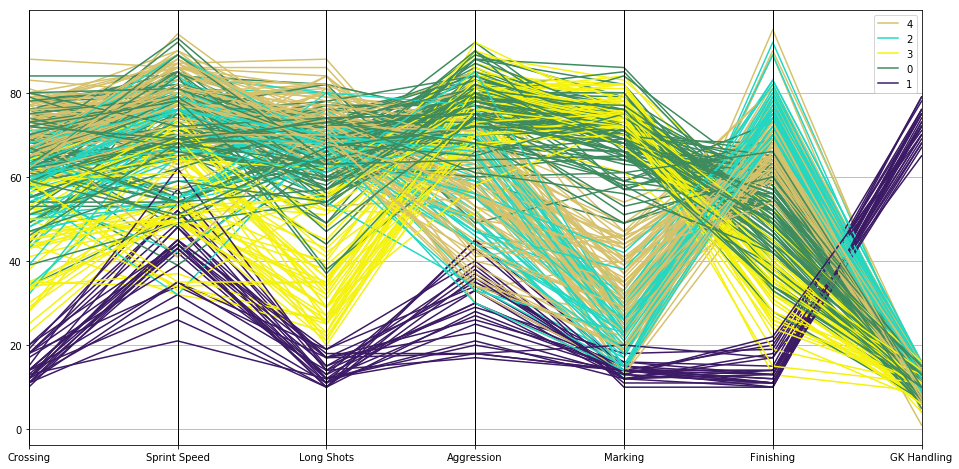

In [6]:
colPlot = ['Crossing', 'Sprint Speed', 'Long Shots', 'Aggression', 'Marking', 'Finishing', 'GK Handling'] + ['Cluster']

plt.figure(figsize=(16,8))
parallel_coordinates(argPlayers.loc[ : , colPlot], 'Cluster')

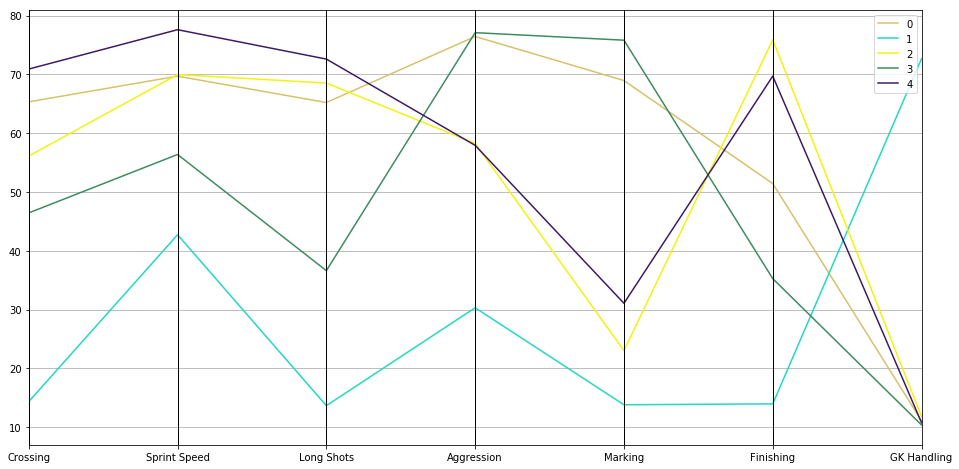

In [7]:
groupedData = argPlayers.groupby(argPlayers['Cluster']).mean()
groupedData['Cluster'] = groupedData.index

plt.figure(figsize=(16,8))
parallel_coordinates(groupedData.loc[ : , colPlot], 'Cluster')

Plot the average of the twelve most important attributes for each cluster.

#### 6. For a new and unknown player, the following attributes are available:

- Crossing: 45
- Sprint Speed: 40
- Long Shots: 35
- Aggression: 45
- Marking: 60
- Finishing: 40
- GK Handling: 15

For each of your 5 clusters from Step 4, compute
player to the nearest cluster based on the distance to the cluster centroids, using only the available attributes.

In [8]:
# Q6
newPlayerAttr = np.array([45, 40, 35, 45, 60, 40, 15]) # Attribute of new player

centroids = kmeans.cluster_centers_
#kmeans.fit(reduced_data)

# Indices of the available attributes
selectedAttrs = [attributes.index('Crossing'), attributes.index('Sprint Speed'), 
                 attributes.index('Long Shots'), attributes.index('Aggression'),
                 attributes.index('Marking'), attributes.index('Finishing'), attributes.index('GK Handling')]

# For each centroid, obtain only the values of selected attributes
centroidsSelected = centroids[ : , selectedAttrs]

# Calculate the distance to each of the 5 centroids, using only these selected attributes
distCentroids = np.linalg.norm(newPlayerAttr - centroidsSelected, axis = 1)

# (500 English Players) closest cluster = Cluster with index 4, centre-backs (defenders) cluster
# (300 Argentina Players) closest cluster = Cluster with index 1, centre-backs (defenders) cluster
np.argmin(distCentroids)

3